In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [2]:
def true_SG(xy): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
    term1 = np.exp(xy[:,0]+xy[:,1]-t_val).reshape(-1,1)
    u = 4.0*np.arctan(term1)
    return u

def BC_func(xy):
    x = xy[:,0].reshape(-1,1)
    y = xy[:,1].reshape(-1,1)
    t = torch.tensor(t_val).float().to(device)
    num = 4.0*torch.exp(x+y+t)
    den = torch.exp(2.0*t) + torch.exp(2.0*x + 2.0*y)
    
    return torch.div(num,den)

In [3]:
loss_thresh = 0
level = "_low"
label = "inv_SG_stan" + level

l_limit = -2.0
u_limit = 2.0

x = np.linspace(l_limit,u_limit,100).reshape(-1,1)
y = np.linspace(l_limit,u_limit,100).reshape(-1,1)

t_val = 2

# t = 3.0*np.ones((1,1))

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

xy_test_tensor = torch.tensor(xy).float().to(device)

u_true = true_SG(xy)
u_true_norm = np.linalg.norm(u_true,2)

lb_xy = xy[0]
ub_xy = xy[-1]

In [4]:
class Sequentialmodel_stan(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        beta_mean = 1.0*torch.ones((50,len(layers)-2))
        beta_std = 0.1*torch.ones((50,len(layers)-2))
        
        self.beta = Parameter(torch.normal(beta_mean,beta_std))
        self.beta.requiresGrad = True
        
        # self.lambdas = torch.tensor([1.0,1.0,1.0,4.0])
        
        self.lambdas = Parameter(torch.tensor([-1.0,-1.0]))
        self.lambdas.requiresGrad = True
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xy - lbxy)/(ubxy - lbxy) - 1.0
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 =self.activation(z)
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
    
#---------------------------------------------
class Sequentialmodel_atanh(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.alpha = Parameter(torch.ones((50,len(layers)-2)))
        self.alpha.requiresGrad = True
        
        # self.lambdas = torch.tensor([1.0,1.0,1.0,4.0])
        
        self.lambdas = Parameter(torch.tensor([-1.0,-1.0]))
        self.lambdas.requiresGrad = True
        
        self.n = torch.tensor(1.5)
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xy - lbxy)/(ubxy - lbxy) - 1.0
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a =self.activation(self.n*self.alpha[:,i]*z)
            # a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
 

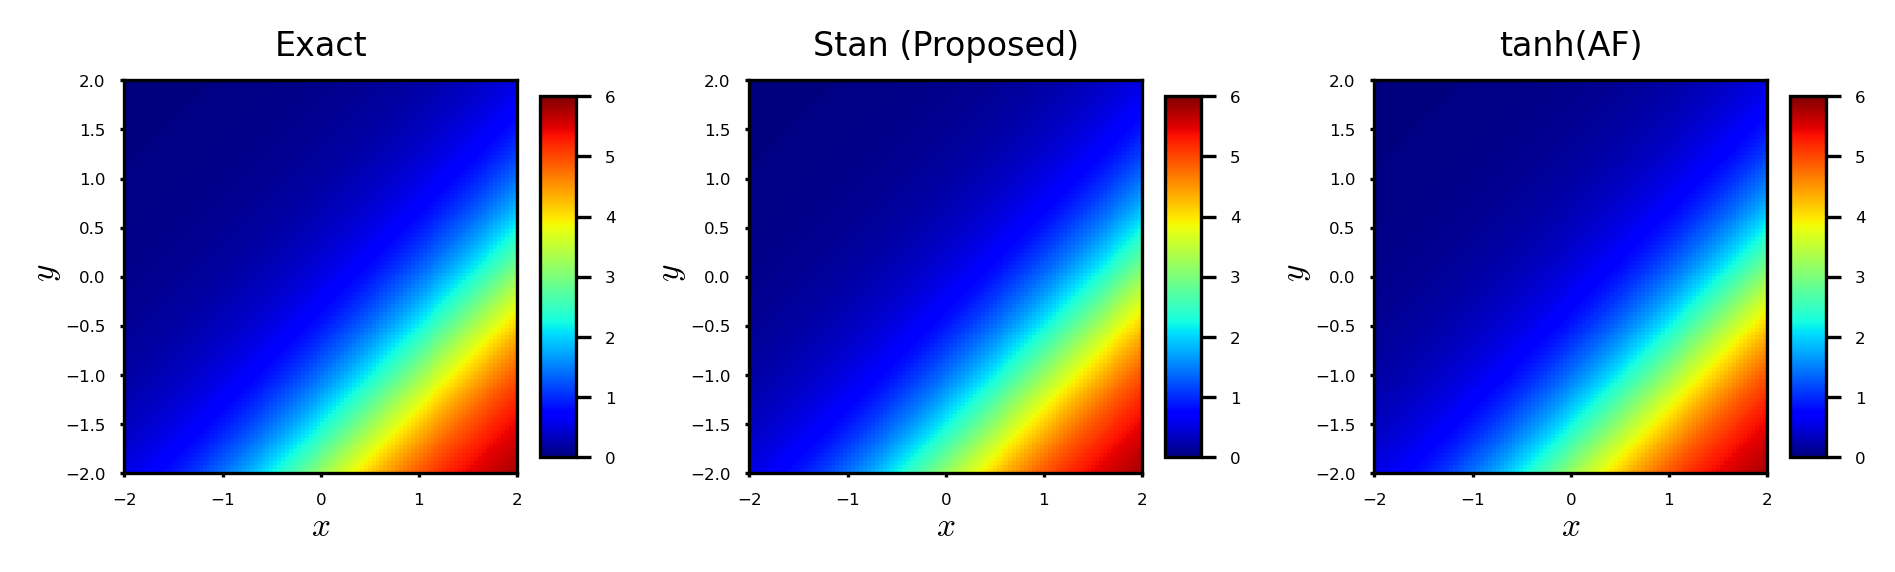

In [12]:
fig, axs = plt.subplots(1,3)
cmap = plt.cm.jet

rep_num = 2

pi = np.pi

loss_thresh = 0.1

fig.dpi=300
fig.tight_layout()

layers = np.array([2,50,50,50,1])

algo_names = ['stan','atanh']
prob_name = "inv_SG_"
# plt_titles = ['Stan (Proposed)','tanh']

PINNs = [Sequentialmodel_stan(layers),Sequentialmodel_atanh(layers)] 
extent = [-2,2,-2,2]

img = axs[0].imshow(u_true.reshape(100,100),vmin = 0,vmax = 6,cmap = cmap,extent=extent)
cbar = fig.colorbar(img, ax=axs[0], aspect = 10, panchor = (0,0),fraction=0.08)
cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False)

rep_num = 0

for i in range(2):
    PINNs[i].load_state_dict(torch.load(prob_name + algo_names[i] + '_low_'+str(rep_num)+'.pt',map_location=device))

    p_pred = PINNs[i].forward(xy_test_tensor).cpu().detach().numpy()
    
    img = axs[i+1].imshow(p_pred.reshape(100,100),vmin = 0,vmax = 6,cmap = cmap,extent=extent) 
    axs[i+1].set_xlabel('$x$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
    axs[i+1].set_ylabel(' $y$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
    axs[i+1].tick_params(axis='x', labelsize=4,length = 1)
    axs[i+1].tick_params(axis='y', labelsize=4,length = 1)
    
    cbar = fig.colorbar(img, ax=axs[i+1], aspect = 10, panchor = (0,0),fraction=0.08)
    cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False)
   
    
# cbar = fig.colorbar(img, ax=axs,location = 'bottom',orientation = 'horizontal', aspect = 100,panchor = (0,-1.5))
# cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False) 
# axs[1,1].set_xlabel('$x$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
# axs[1,1].set_ylabel(' $y$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
# axs[1,1].tick_params(axis='x', labelsize=4,length = 1)
# axs[1,1].tick_params(axis='y', labelsize=4,length = 1)


# cbar = fig.colorbar(img1, ax=axs,location = 'bottom',orientation = 'horizontal', aspect = 100, panchor = (0,-4.75))
# cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False) 
axs[0].set_xlabel('$x$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
axs[0].set_ylabel(' $y$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
axs[0].tick_params(axis='x', labelsize=4,length = 1)
axs[0].tick_params(axis='y', labelsize=4,length = 1)

fig.subplots_adjust(top = 1.0,bottom = 0.6)

plt_titles = ['Exact','Stan (Proposed)','tanh(AF)']
for i in range(3):
    axs[i].set_title(plt_titles[i],fontsize=8, math_fontfamily='cm')
    
# plt.savefig('KG_'+level +'_pred_error.png', format='png',pad_inches=0, bbox_inches='tight',transparent=True)    
plt.savefig('Inv_SG_pred.pdf', format='pdf',pad_inches=0, bbox_inches='tight',transparent=True)